<a href="https://colab.research.google.com/github/carlibeisel/mason_water_budget/blob/main/reach_landuse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Carli Beisel

September 16, 2024

Purpose: Identify urban proportion and crop type in each reach within Mason

## Urbanization

In [ ]:
# ------------------ #
#  Import Libraries  #
# ------------------ #
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
! pip install rasterio
import rasterio
import rasterio.features
from rasterio.mask import mask
from rasterio import mask
from rasterio.crs import CRS
import glob
import os
import json

#connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# --------------- #
#   Load Files    #
# --------------- #

reaches = gpd.read_file('/content/drive/MyDrive/Data/Mason/data_input/reach_shapefile/Reach_Final/Reach_Final.shp')

#cdl
cdl = rasterio.open('/content/drive/MyDrive/Data/Mason/data_input/land_cover/mason_cdl/mason2023.tif')

# FWT shapefile of irrigation type based on ML, satellite imagery, & OpenET
irrigation_type = gpd.read_file('/content/drive/MyDrive/Data/Mason/data_input/fwt_irrigation_runoff/mason_creek_fields/mason_creek_fields.shp')

In [ ]:
# --------------- #
# Area of each reach
# --------------- #

# Calculate the area in square meters (or square feet depending on the CRS)
reaches['area'] = reaches.geometry.area
reach_areas = reaches[['Name', 'area']]
print(reach_areas)
reaches['area_km2'] = reaches['area'] / 1_000_000

# Display the reach ID and corresponding area in square kilometers
reach_areas_km2 = reaches[['Name', 'area_km2']]
print(reach_areas_km2)

# Convert area to square miles
reaches['area_mi2'] = reaches['area'] / 2_589_988.11
reach_areas_mi2 = reaches[['Name', 'area_mi2']]
print(reach_areas_mi2)

            Name      area
0    Noble Drain  0.001078
1        Reach 1  0.000791
2   Purdum Reach  0.000490
3  Solomon Reach  0.000388
4        Reach 2  0.000335
5        Reach 3  0.001411
6        Reach 4  0.000228
            Name      area_km2
0    Noble Drain  1.077654e-09
1        Reach 1  7.905772e-10
2   Purdum Reach  4.896739e-10
3  Solomon Reach  3.879509e-10
4        Reach 2  3.349452e-10
5        Reach 3  1.411197e-09
6        Reach 4  2.284644e-10
            Name      area_mi2
0    Noble Drain  4.160846e-10
1        Reach 1  3.052435e-10
2   Purdum Reach  1.890642e-10
3  Solomon Reach  1.497887e-10
4        Reach 2  1.293230e-10
5        Reach 3  5.448661e-10
6        Reach 4  8.821062e-11


<ipython-input-44-244406496c44>:6: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  reaches['area'] = reaches.geometry.area


In [ ]:
## ------------------------------ ##
##  Mask CDL Layer to Each Reach  ##
## ------------------------------ ##

shp_file = gpd.read_file('/content/drive/MyDrive/Data/Mason/data_input/reach_shapefile/Reach_Final/Reach_Final.shp')
cdl = rasterio.open('/content/drive/MyDrive/Data/Mason/data_input/land_cover/mason_cdl/mason2023.tif')
output_dir = '/content/drive/MyDrive/Data/Mason/data_input/land_cover/masked_2023'


shp = shp_file.to_crs(cdl.crs) # shapefile is in the same CRS as the raster

# Loop through each geometry in the shapefile and crop the raster
for i, row in shp.iterrows():
    geometry = row['geometry']
    coords = [json.loads(gpd.GeoSeries(geometry).to_json())['features'][0]['geometry']]
    out_img, out_transform = mask(dataset=cdl, shapes=coords, crop=True, nodata=0)
    out_meta = cdl.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": out_img.shape[1],
        "width": out_img.shape[2],
        "transform": out_transform
    })

    feature_name = row['Name'] # Name category is reach
    out_filename = os.path.join(output_dir, f'{feature_name}.tif')
    with rasterio.open(out_filename, 'w', **out_meta) as out_tiff:
        out_tiff.write(np.squeeze(out_img, 0), 1)

    print(f'Cropped raster saved to {out_filename}')

TypeError: 'numpy.ndarray' object is not callable

In [ ]:
# ---------------------------- #
#    Characterization: Urban
# ---------------------------- #

masked_cdl_dir = '/content/drive/MyDrive/Data/Mason/data_input/land_cover/masked_2023/'

# characterize urban land from cdl data
developed_crop_types = {
    82,   # developed
    121,  # openspace
    122,  # low intensity
    123,  # med intensity
    124,  # high intensity
    62,   # pasture
    176   # pasture
}

SQM_TO_SQMI = 2_589_988.11 # conversion from square meters to square miles
data = []
masked_files = glob.glob(os.path.join(masked_cdl_dir, '*.tif'))
for file_path in masked_files: # loop through each reach
    reach_name = os.path.basename(file_path).replace('.tif', '')  # extract reach name from the file name
    print(f'Processing file for reach: {reach_name}')
    with rasterio.open(file_path) as src:
        cdl_data = src.read(1)
        pixel_width = src.transform[0]   # Pixel width
        pixel_height = -src.transform[4] # Pixel height
        pixel_area = pixel_width * pixel_height  # Area of one pixel in square meters
        unique_crop_types, pixel_counts = np.unique(cdl_data, return_counts=True)

        # Initialize pixel counts
        total_pixels = 0
        developed_pixels = 0
        high_intensity_pixels = 0
        medium_intensity_pixels = 0
        low_intensity_pixels = 0
        open_space_pixels = 0
        pasture_pixels = 0

        # count pixels for each urbanization type
        for crop_type, count in zip(unique_crop_types, pixel_counts):
            total_pixels += count  # Count total number of pixels
            if crop_type in developed_crop_types:
                developed_pixels += count  # Count developed land pixels
                if crop_type == 124:  # High intensity
                    high_intensity_pixels += count
                elif crop_type == 123:  # Medium intensity
                    medium_intensity_pixels += count
                elif crop_type == 122:  # Low intensity
                    low_intensity_pixels += count
                elif crop_type == 121:  # Open space
                    open_space_pixels += count
                elif crop_type == 62: #pasture
                    pasture_pixels += count
                elif crop_type == 176: #pasture/grassland
                    pasture_pixels += count

        # Calculate areas in square meters
        total_area_m2 = total_pixels * pixel_area
        developed_area_m2 = developed_pixels * pixel_area
        high_intensity_area_m2 = high_intensity_pixels * pixel_area
        medium_intensity_area_m2 = medium_intensity_pixels * pixel_area
        low_intensity_area_m2 = low_intensity_pixels * pixel_area
        open_space_area_m2 = open_space_pixels * pixel_area
        pasture_area_m2 = pasture_pixels * pixel_area

        # Convert areas to square miles
        total_area_mi2 = total_area_m2 / SQM_TO_SQMI
        developed_area_mi2 = developed_area_m2 / SQM_TO_SQMI
        high_intensity_area_mi2 = high_intensity_area_m2 / SQM_TO_SQMI
        medium_intensity_area_mi2 = medium_intensity_area_m2 / SQM_TO_SQMI
        low_intensity_area_mi2 = low_intensity_area_m2 / SQM_TO_SQMI
        open_space_area_mi2 = open_space_area_m2 / SQM_TO_SQMI
        pasture_area_mi2 = pasture_area_m2 / SQM_TO_SQMI

        # Calculate proportion of developed land
        if total_area_mi2 > 0:
            percent_developed = 100 * (developed_area_mi2 / total_area_mi2)
        else:
            percent_developed = 0

        # Append the data for this reach
        data.append({
            'Reach': reach_name,
            'Area of Reach (mi²)': total_area_mi2,
            'Urban Land Cover Area (mi²)': developed_area_mi2,
            'High Intensity Urban (mi²)': high_intensity_area_mi2,
            'Medium Intensity Urban (mi²)': medium_intensity_area_mi2,
            'Low Intensity Urban (mi²)': low_intensity_area_mi2,
            'Open Space Urban (mi²)': open_space_area_mi2,
            'Percent of Urban Land': percent_developed,
            'Pasture (mi²)': pasture_area_mi2
        })

urban = pd.DataFrame(data)
urban

Processing file for reach: Noble Drain
Processing file for reach: Reach 1
Processing file for reach: Purdum Reach
Processing file for reach: Solomon Reach
Processing file for reach: Reach 2
Processing file for reach: Reach 3
Processing file for reach: Reach 4


,Reach,Area of Reach (mi²),Urban Land Cover Area (mi²),High Intensity Urban (mi²),Medium Intensity Urban (mi²),Low Intensity Urban (mi²),Open Space Urban (mi²),Percent of Urban Land,Pasture (mi²)
0,Noble Drain,14.667635,1.926843,0.149769,0.320735,0.432280,0.511161,13.136697,0.512898
1,Reach 1,5.863927,2.420281,0.195985,0.563632,0.777687,0.735988,41.274074,0.146989
2,Purdum Reach,6.222886,1.177650,0.007297,0.089653,0.316565,0.410040,18.924503,0.354094
3,Solomon Reach,3.277544,0.841625,0.008687,0.102858,0.245329,0.284596,25.678541,0.200155
4,Reach 2,2.749356,0.562242,0.000695,0.031274,0.126140,0.211623,20.449949,0.192511
5,Reach 3,14.142922,1.182515,0.029537,0.093823,0.139692,0.342280,8.361179,0.577184
6,Reach 4,1.966109,0.217182,0.000000,0.001390,0.021197,0.062896,11.046306,0.131699


## Irrigation Type


In [2]:
# ------------------ #
#  Import Libraries  #
# ------------------ #
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

#connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# --------------- #
#   Load Files    #
# --------------- #
reaches = gpd.read_file('/content/drive/MyDrive/Data/Mason/data_input/reach_shapefile/Reach_Final/Reach_Final.shp')
# FWT shapefile of irrigation type based on ML, satellite imagery, & OpenET
irrigation_type = gpd.read_file('/content/drive/MyDrive/Data/Mason/data_input/fwt_irrigation_runoff/mason_creek_fields/mason_creek_fields.shp')

In [ ]:
# ----------------------------------- #
#   Irrigation Type for each Reach    #
# ----------------------------------- #

# Reproject the irrigation shapefile to match the CRS of the reaches shapefile
irrigation_type = irrigation_type.to_crs(reaches.crs)

# Perform the intersection between reaches and irrigation type geometries
intersection = gpd.overlay(reaches, irrigation_type, how='intersection')

# Calculate the area of each intersected polygon in square meters using the geometry column
intersection['area_m2'] = intersection.geometry.area

# Conversion factor from square meters to square miles
SQM_TO_SQMI = 2_589_988.11

# Convert the area to square miles
intersection['area_mi2'] = intersection['area_m2'] / SQM_TO_SQMI

# Group by reach and irrigation type to calculate the total area of each irrigation type per reach
irrigation_areas_by_reach = intersection.groupby(['Name', 'irr_type'])['area_mi2'].sum().reset_index()

# Create a pivot table to get the irrigation type areas for each reach
irrig_type = irrigation_areas_by_reach.pivot(index='Name', columns='irr_type', values='area_mi2').fillna(0)

# Calculate the total irrigated area (in square miles) for each reach
irrig_type['Total Irrigated Area (mi²)'] = irrig_type.sum(axis=1)

# Reset the index and rename the 'Name' column to 'Reach'
irrig_type = irrig_type.reset_index()
irrig_type = irrig_type.rename(columns={'Name': 'Reach'})

# Display the final DataFrame
irrig_type

irr_type,Reach,Flood,Not Irrigated,Sprinkler,Total Irrigated Area (mi²)
0,Noble Drain,0.949379,0.049523,0.172317,1.171219
1,Purdum Reach,0.404203,0.000000,0.000000,0.404203
2,Reach 1,0.071626,0.021165,0.063984,0.156775
3,Reach 2,0.453093,0.009752,0.000000,0.462845
4,Reach 3,3.131777,0.019219,0.019298,3.170294
5,Reach 4,0.444676,0.012424,0.009488,0.466587
6,Solomon Reach,0.226912,0.017209,0.027072,0.271193


In [ ]:
# -------------------------- #
## Combine Data & Load File
# -------------------------- #

# Combine the two data frame
land_use = pd.merge(urban, irrig_type, on='Reach', how='left')
land_use.to_csv('/content/drive/MyDrive/Data/Mason/data_output/land_use/land_use.csv', index=False)

file = pd.read_csv('/content/drive/MyDrive/Data/Mason/data_output/land_use/land_use.csv')

## Stacked Bar Plot of Urban + Irrig Type for Each Reach

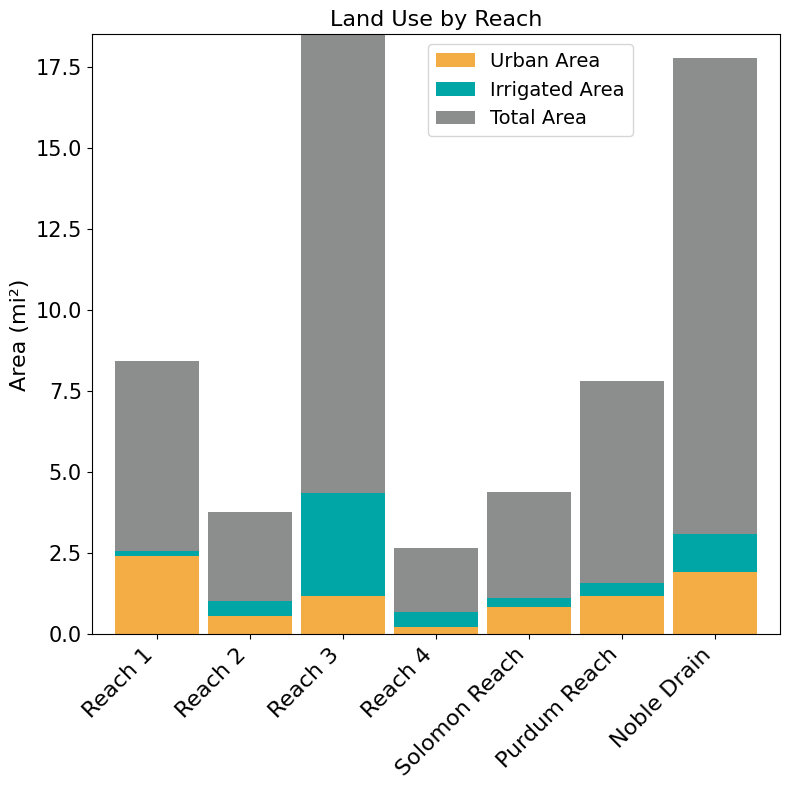

In [4]:
## ------- ##
#   Figure
## ------- ##
file = pd.read_csv('/content/drive/MyDrive/Data/Mason/data_output/land_use/land_use.csv')

custom_order = ['Reach 1', 'Reach 2', 'Reach 3', 'Reach 4', 'Solomon Reach', 'Purdum Reach', 'Noble Drain']
file = file.set_index('Reach').loc[custom_order]
custom_colors = ['#F4AC45', '#00A6A6', '#8C8D8D']
fig, ax = plt.subplots(figsize=(8, 8))
file[['Urban Land Cover Area (mi²)', 'Total Irrigated Area (mi²)', 'Area of Reach (mi²)']].plot(
    kind='bar', stacked=True, ax=ax, width=0.9, color=custom_colors)
ax.set_xlabel('', fontsize= 16)
ax.set_ylabel('Area (mi²)', fontsize= 16)
ax.set_title('Land Use by Reach', fontsize= 16)
plt.xticks(rotation=45, ha='right', fontsize= 16)
plt.yticks(fontsize= 15)
max_area = file[['Urban Land Cover Area (mi²)', 'Total Irrigated Area (mi²)', 'Area of Reach (mi²)']].sum(axis=1).max()
ax.set_ylim(0, max_area * 1)
plt.legend(title="Land Use")

legend_labels = ['Urban Area', 'Irrigated Area', 'Total Area']
plt.legend(legend_labels, loc="upper right", bbox_to_anchor=(0.8, 1), fontsize= 14)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Carli Thesis/Figures/Water Budget/reach_land_use.png', dpi=300, bbox_inches='tight')
plt.show()